In [4]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

from skimage.transform import resize

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

(512, 512)


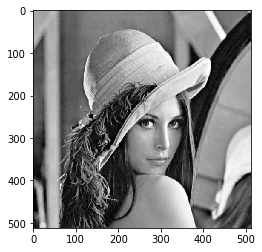

In [5]:
im = imread("../imageProcessing/samples/lena.jpg", pilmode="L")

plt.imshow(im, cmap="gray")
print(im.shape)
plt.show()

In [6]:
def normalize(im):
    """
        Small helper function for image renormalization
    """
    im = im.astype(np.float32)
    im -= im.min()
    im /= im.max()
    return im

def DFT(im, shift=False):
    """
        Transforms an image to Fourier Domain 
    """
    
    I = fft2(im)
    
    if shift:
        I = fftshift(I)
    
    return I

def maskDFT(mask, size, shift=False):
    """
        Transforms a filter mask to Fourier Domain 
        according to the given size
    """
    
    h, w = size
    f_h, f_w = mask.shape
    d_h, d_w = h - f_h, w - f_w
    
    padding =[
        (
            int(np.ceil(d_h / 2)),
            int(np.floor(d_h / 2)),
        ), (
            int(np.ceil(d_w / 2)),
            int(np.floor(d_w / 2)),
        )
    ]
    mask = fftshift(np.pad(mask, padding, mode="constant"))
    
    return DFT(mask, shift=shift)

def iDFT(I, shift=False):
    """
        Transforms an image back from Fourier to Spatial Domain 
    """
    
    if shift:
        I = ifftshift(I)
    
    im = ifft2(I)
    
    return im.real

# Exercise 4: Inverse Filtering

Using the functions above for Fourier Transformations implement the inverse filtering approach!
Think about the following in advance:

1. How to model different degradation processes? Implement functions, that apply motion or atmospheric blur to an input image!
2. How to model a noise process? Implement a function, that applies Gaussian noise to an input image!
3. Create from an image a (1) *degraded image* and (2) a *degraded image with noise*. Visualize the resulting images and the degradation filters!
4. Now implement a function, that applies inverse filtering based on an image and a degradation filter (represented in Frequency Domain!). Use this function to restore the (1) *degraded image* and the (2) *degraded image with noise* from previous step. Visualize the results!
5. What can be seen? Try out different noise strength and interpret the results!

## Solution

In [7]:
def gaussian(size, sigma=1):
    """
        creates gaussian kernel with a given size and sigma
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()

def motion(size):
    res = np.zeros((size, size))
    res[size // 2] = 1
    return res / res.sum()

def box(size):
    res = np.ones((size, size))
    return res / res.sum()

In [8]:
def degradation(im, mask, factor=0.1):
    
    I = DFT(im, shift=True)
    H = maskDFT(mask, im.shape, shift=True)
    res = iDFT(I * H, shift=True).real
    
    return res, H

In [9]:
def noise(im, strength=0.1):
    n = np.random.normal(size=im.shape) 
    n *= im.max() * strength
    return im + n

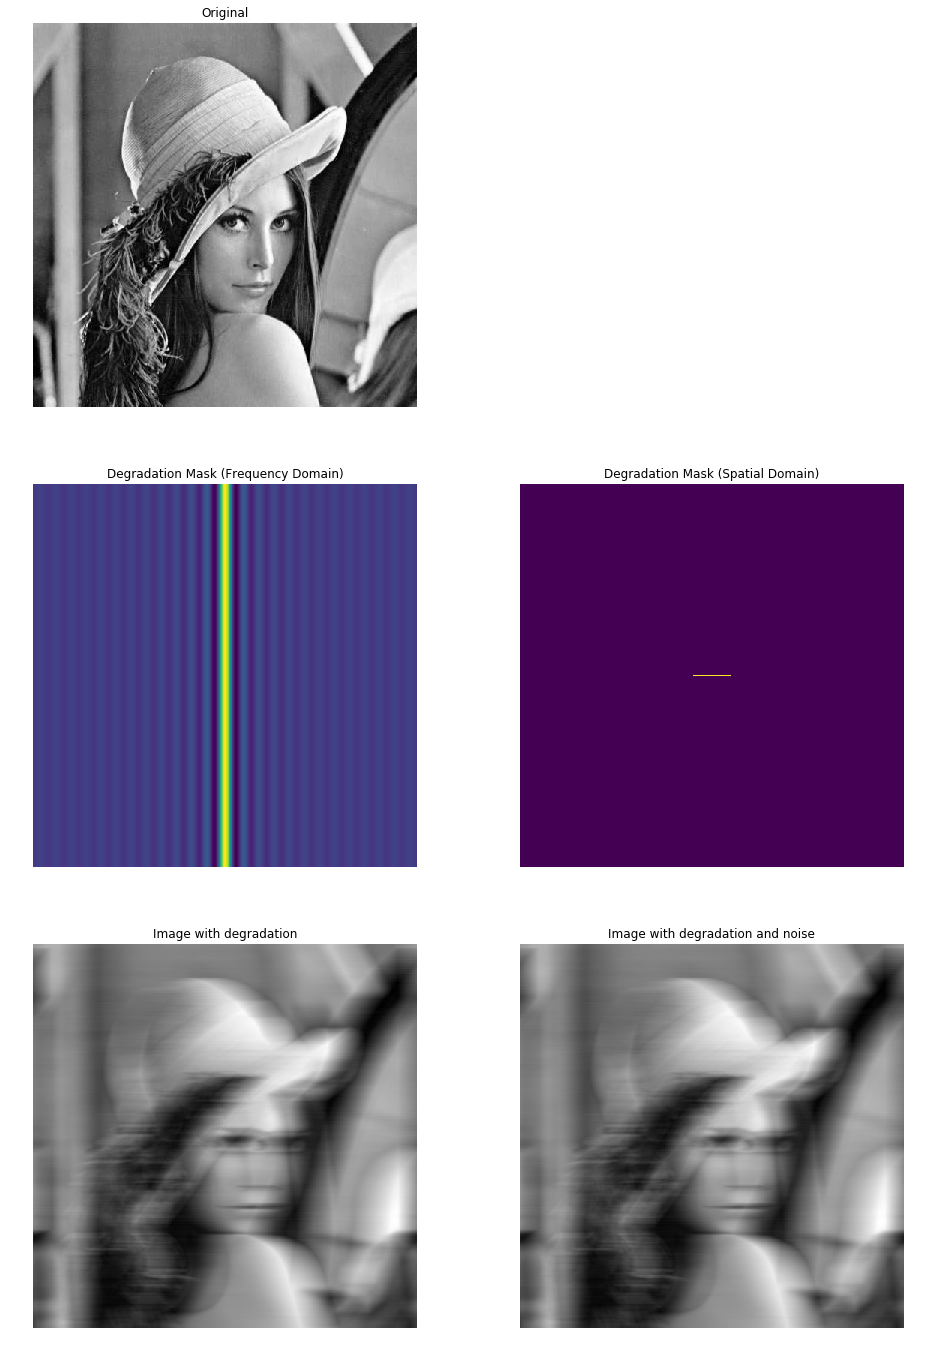

In [10]:
im_orig = normalize(im)

size = int(max(im_orig.shape) * 0.1)

gauss_mask = gaussian(size=size, sigma=np.sqrt(size)*1.5)

box_mask = box(size)

motion_mask = motion(size)

# im_deg, H = degradation(im_orig, gauss_mask)
im_deg, H = degradation(im_orig, motion_mask)
# im_deg, H = degradation(im_orig, box_mask)

im_noisy = noise(im_deg, 1e-3)

fig, axs = plt.subplots(3,2, figsize=(16,24))
[ax.axis("off") for ax in axs.ravel()]

axs[0, 0].imshow(im_orig, cmap=plt.cm.gray)
axs[0, 0].set_title("Original")

axs[1, 0].imshow(H.real)
axs[1, 0].set_title("Degradation Mask (Frequency Domain)")

axs[1, 1].imshow(fftshift(iDFT(H, shift=True)).real)
axs[1, 1].set_title("Degradation Mask (Spatial Domain)")

axs[2, 0].imshow(im_deg, cmap=plt.cm.gray)
axs[2, 0].set_title("Image with degradation")

axs[2, 1].imshow(im_noisy, cmap=plt.cm.gray)
axs[2, 1].set_title("Image with degradation and noise")

plt.show()

In [11]:
def inverse_filter(im, mask, eps=1e-20):

    I = DFT(im, shift=True)
    H = mask.copy()
    
    stability_mask = np.logical_or(H < -eps, eps < H)
    
    R = np.zeros_like(I)
    R[stability_mask] = I[stability_mask] / H[stability_mask]
    
    res = iDFT(R, shift=True)
    return res
    

Pixels restored: 99.8558%
Pixels restored: 0.0000%


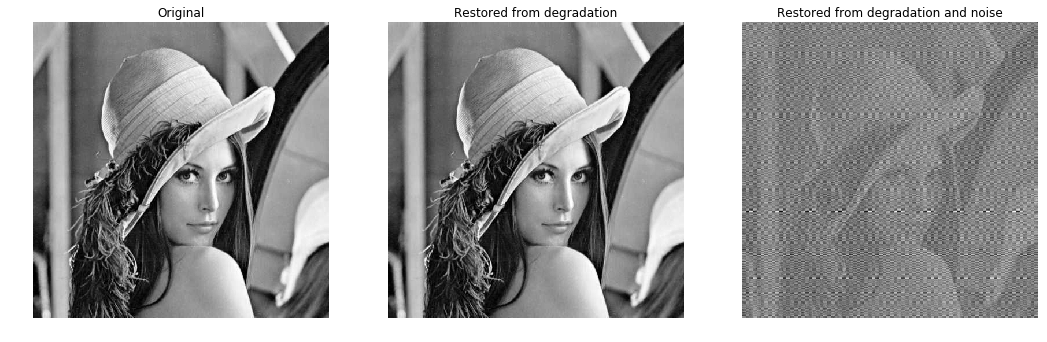

In [12]:
restored_im_deg = inverse_filter(im_deg, H)
restored_im_noisy = inverse_filter(im_noisy, H)

print("Pixels restored: {:.4%}".format(np.isclose(im_orig, restored_im_deg).mean()))
print("Pixels restored: {:.4%}".format(np.isclose(im_orig, restored_im_noisy).mean()))

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
[a.axis("off") for a in ax]

### Visualize the results!

ax[0].imshow(im_orig, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(restored_im_deg, cmap=plt.cm.gray)
ax[1].set_title("Restored from degradation")

ax[2].imshow(restored_im_noisy, cmap=plt.cm.gray)
ax[2].set_title("Restored from degradation and noise")

plt.show()

In [ ]:
dd